<a href="https://colab.research.google.com/github/arsalanmontazeri/Arsalan-Montazeri/blob/world-bank/world_bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For displaying all of the columns in dataframes
pd.set_option('display.max_column',None)
# For data modeling
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
# For saving models
import pickle

In [2]:
df=pd.read_csv('world_bank_dataset.csv')

In [3]:
df.head()

,Country,Year,GDP (USD),Population,Life Expectancy,Unemployment Rate (%),CO2 Emissions (metric tons per capita),Access to Electricity (%)
0,Brazil,2010,1.493220e+12,829020000.0,66.7,3.81,10.79,76.76
1,Japan,2011,1.756270e+13,897010000.0,61.4,17.98,15.67,67.86
2,India,2012,1.642688e+13,669850000.0,69.1,16.02,2.08,81.08
3,Mexico,2013,1.189001e+13,113800000.0,80.1,6.26,19.13,53.46
4,India,2014,2.673020e+12,29710000.0,62.7,3.10,15.66,82.17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Country                                 200 non-null    object 
 1   Year                                    200 non-null    int64  
 2   GDP (USD)                               200 non-null    float64
 3   Population                              200 non-null    float64
 4   Life Expectancy                         200 non-null    float64
 5   Unemployment Rate (%)                   200 non-null    float64
 6   CO2 Emissions (metric tons per capita)  200 non-null    float64
 7   Access to Electricity (%)               200 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 12.6+ KB


In [5]:
df.shape

(200, 8)

In [6]:
df.isna().sum()

,0
Country,0
Year,0
GDP (USD),0
Population,0
Life Expectancy,0
Unemployment Rate (%),0
CO2 Emissions (metric tons per capita),0
Access to Electricity (%),0


           Country  count
0            India     15
1   United Kingdom     13
2        Indonesia     13
3     Saudi Arabia     13
4            Italy     12
5           France     12
6        Argentina     12
7    United States     11
8           Mexico     10
9           Canada     10
10           Japan     10
11         Nigeria      9
12          Turkey      9
13    South Africa      8
14          Russia      8
15           China      8
16         Germany      7
17       Australia      7
18          Brazil      7
19     South Korea      6


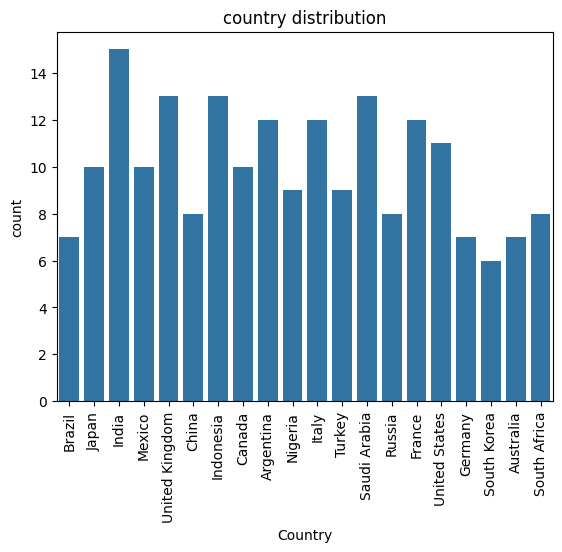

In [7]:
print(df['Country'].value_counts().reset_index())
sns.countplot(data=df,x='Country')
plt.xticks(rotation=90)
plt.title('country distribution')
plt.show()

In [8]:
min_year = df['Year'].min()
max_year = df['Year'].max()

year_range = (min_year, max_year)
print("Range of years:", year_range)

Range of years: (2010, 2019)


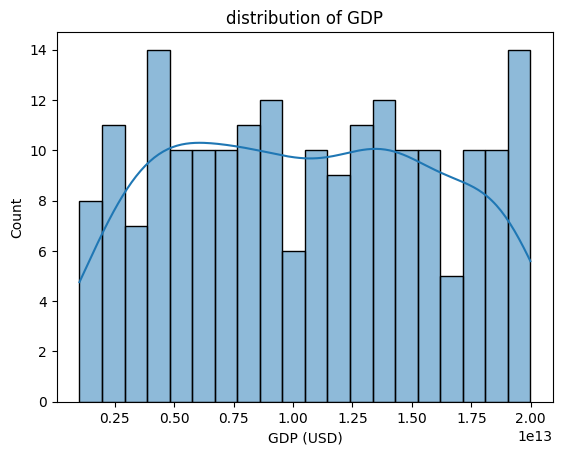

In [9]:
sns.histplot(data=df,x='GDP (USD)',bins=20,kde=True)
plt.title('distribution of GDP')
plt.show()

In [10]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'category_column' is your categorical column
df['Country_encoded'] = LabelEncoder().fit_transform(df['Country'])


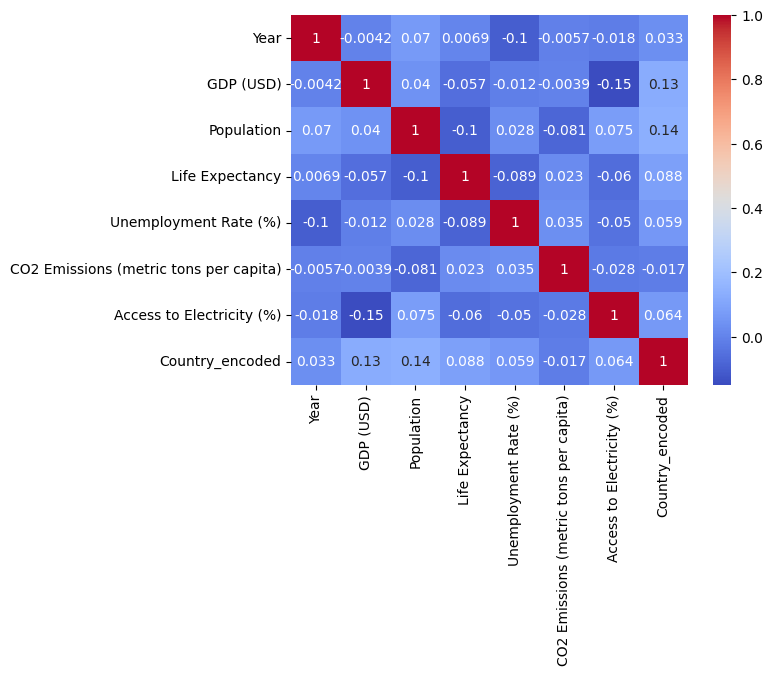

Year                                      0.006905
GDP (USD)                                -0.057118
Population                               -0.099693
Life Expectancy                           1.000000
Unemployment Rate (%)                    -0.089002
CO2 Emissions (metric tons per capita)    0.023015
Access to Electricity (%)                -0.059594
Country_encoded                           0.087909
Name: Life Expectancy, dtype: float64


In [11]:
# Select only numeric features for correlation analysis
numeric_features = df.select_dtypes(include=['number'])

# Calculate correlation matrix
corr = numeric_features.corr()

# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

print(corr['Life Expectancy'])

In [12]:
new_df=df.groupby(['Country','Year'])[['GDP (USD)','Life Expectancy','Unemployment Rate (%)','CO2 Emissions (metric tons per capita)','Access to Electricity (%)','Population']].mean().sort_values(by=['GDP (USD)'], ascending=False).reset_index()
new_df.head()

,Country,Year,GDP (USD),Life Expectancy,Unemployment Rate (%),CO2 Emissions (metric tons per capita),Access to Electricity (%),Population
0,United States,2019,1.997029e+13,65.7,17.920,2.570,72.170,1.184630e+09
1,China,2011,1.965542e+13,52.1,19.880,2.640,57.070,6.757000e+07
2,United States,2010,1.963537e+13,65.5,18.010,16.990,97.580,7.059300e+08
3,Italy,2015,1.960347e+13,62.9,15.935,8.495,74.175,5.098050e+08
4,Germany,2010,1.957240e+13,82.3,19.460,4.110,60.410,8.202400e+08


In [20]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Country                                 129 non-null    object 
 1   Year                                    129 non-null    int64  
 2   GDP (USD)                               129 non-null    float64
 3   Life Expectancy                         129 non-null    float64
 4   Unemployment Rate (%)                   129 non-null    float64
 5   CO2 Emissions (metric tons per capita)  129 non-null    float64
 6   Access to Electricity (%)               129 non-null    float64
 7   Population                              129 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 8.2+ KB


In [23]:
fig = px.choropleth(
    df,
    locations="Country",  # name of the column with country names
    locationmode="country names",  # tells Plotly to use country names
    color="GDP (USD)",  # column to display on map
    hover_name="Country",  # column to show in hover
    title="GDP by Country",
    color_continuous_scale="Viridis"  # color scale
)

fig.update_geos(showcoastlines=True, coastlinecolor="Black")
fig.show()

In [13]:
US=new_df[new_df['Country']=='United States']

<Axes: xlabel='Year', ylabel='Life Expectancy'>

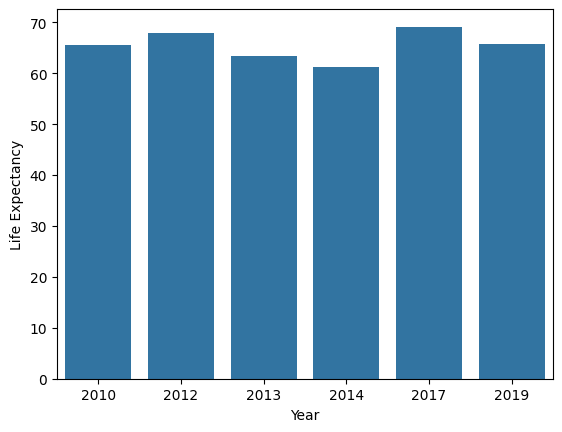

In [14]:
sns.barplot(data=US,x='Year',y='Life Expectancy')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, '7.053333333333334'),
  Text(1, 0, '14.350000000000001'),
  Text(2, 0, '16.73'),
  Text(3, 0, '17.92'),
  Text(4, 0, '18.01'),
  Text(5, 0, '24.74')])

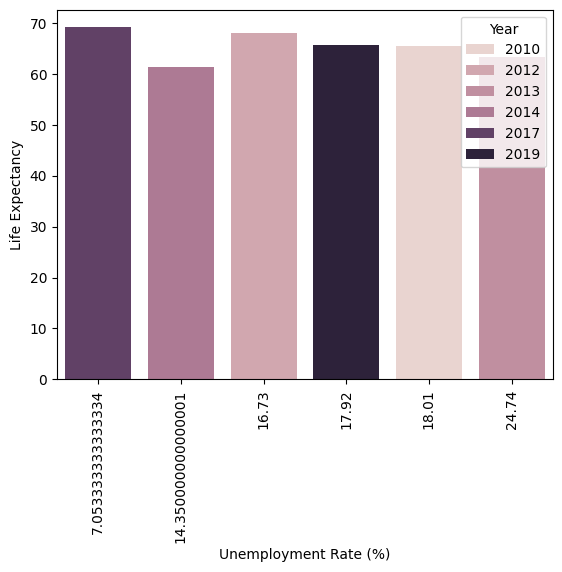

In [15]:
sns.barplot(data=US,y='Life Expectancy',x='Unemployment Rate (%)',hue='Year')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, '61.3'),
  Text(1, 0, '63.3'),
  Text(2, 0, '65.5'),
  Text(3, 0, '65.7'),
  Text(4, 0, '67.96666666666667'),
  Text(5, 0, '69.13333333333334')])

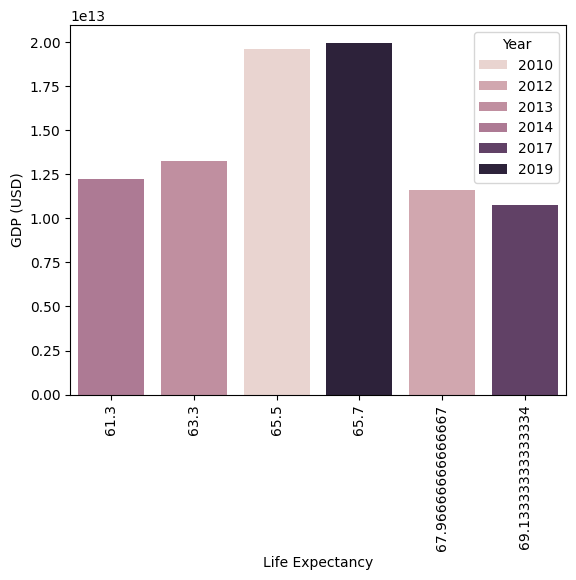

In [16]:
sns.barplot(data=US,y='GDP (USD)',hue='Year',x='Life Expectancy')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, '61.3'),
  Text(1, 0, '63.3'),
  Text(2, 0, '65.5'),
  Text(3, 0, '65.7'),
  Text(4, 0, '67.96666666666667'),
  Text(5, 0, '69.13333333333334')])

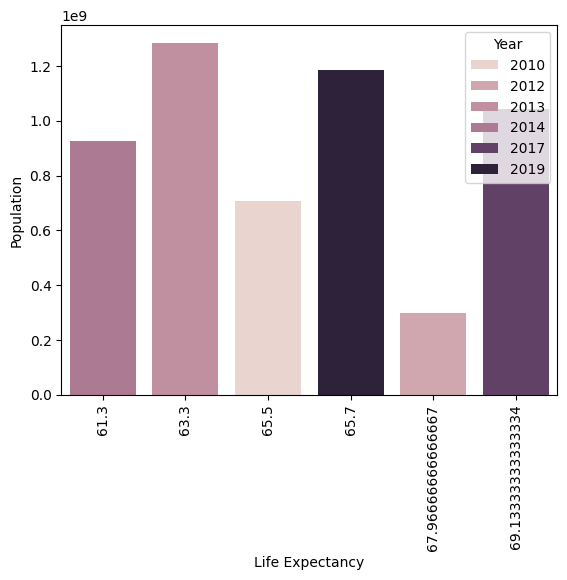

In [17]:
sns.barplot(data=US,y='Population',hue='Year',x='Life Expectancy')
plt.xticks(rotation=90)

In [18]:
import plotly.express as px
import geopandas as gpd